# Metadata

```yaml
Course:    DS 5001
Module:    12 Lab
Topic:     Multinomial Classification
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Set Up

## Configure

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

**Set some parameters**

We create an empty static class to store our parameters.

In [3]:
class Params:
    test_size = 0.20
    smooth_alpha = .1

## Import

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import plotly_express as px

# Preparation

## Import wine reviews

In [5]:
docs = pd.read_csv(f'{data_path}.csv', index_col='doc_id')

In [6]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


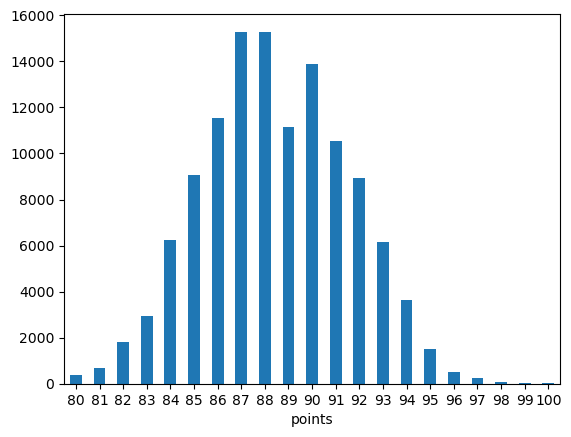

In [7]:
docs.points.value_counts().sort_index().plot.bar(rot=0);

## Convert points to labels

In [10]:
class_labels = ['A', 'B', 'C']

In [11]:
CLASS = pd.DataFrame(index=class_labels)

In [272]:
b_lower = 87
a_lower = 90

In [273]:
docs['doc_label'] = 'C'
docs.loc[docs.points >= b_lower, 'doc_label'] = 'B'
docs.loc[docs.points >= a_lower, 'doc_label'] = 'A'

## Balance sample

In [274]:
CLASS['doc_count'] = docs.value_counts('doc_label').to_frame()

In [275]:
CLASS

,n,log,doc_count
doc_label,,,
A,558049,-1.400639,45585
B,496207,-1.570089,41714
C,419097,-1.813747,32679


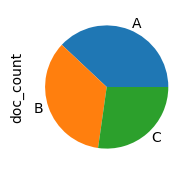

In [276]:
CLASS.doc_count.plot.pie(figsize=(2,2));

In [277]:
G1 = docs.groupby('doc_label')

In [278]:
G1.count()

,doc_content,points
doc_label,,
A,45585,45585
B,41714,41714
C,32679,32679


In [280]:
n_samples = CLASS.doc_count.min()

In [281]:
n_samples

32679

In [282]:
DOC = pd.concat([G1.get_group(class_name).sample(n_samples) for class_name in G1.groups.keys()]).sort_index()

In [283]:
CM / CM.sum()

doc_label,A,B,C
prediction,,,
A,0.699645,0.310056,0.096826
B,0.252370,0.481644,0.230847
C,0.047986,0.208300,0.672327


## Divide docs into train and test sets

We remove stopwords and use a binary count.

We don't use TFIDF, although it would be interesting to try that.

In [284]:
count_engine = CountVectorizer(stop_words='english', binary=True)
count_model = count_engine.fit_transform(DOC.doc_content)
DTM = pd.DataFrame(count_model.toarray(), columns=count_engine.get_feature_names_out(), index=DOC.index)
X_train, X_test, y_train, y_test = train_test_split(DTM, DOC.doc_label, test_size=Params.test_size, random_state=0)

In [285]:
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_trdy = y_test.sort_index()

## Apply labels to tokens

In [286]:
TOKEN_CLASS = X_train.join(y_train).groupby('doc_label').sum().T

In [287]:
TOKEN_CLASS.sample(10)

doc_label,A,B,C
boston,0,0,3
shaping,2,0,0
colonel,1,0,0
eden,10,8,0
salcheto,0,1,0
br,0,0,1
fransola,0,0,0
vengeance,0,0,0
farewell,1,0,0
select,14,13,5


# Training 

In [288]:
TOKEN_CLASS_SMOOTH = TOKEN_CLASS + Params.smooth_alpha

In [289]:
TOKEN_CLASS_LOG = np.log2(TOKEN_CLASS_SMOOTH / TOKEN_CLASS_SMOOTH.sum())

In [290]:
TOKEN_CLASS_LOG

doc_label,A,B,C
000,-13.736647,-13.498186,-13.173381
008,-22.761786,-19.063894,-22.279289
01,-17.404234,-19.063894,-22.279289
02,-19.302355,-18.131008,-18.819858
03,-16.831049,-19.063894,-16.606864
...,...,...,...
été,-19.302355,-22.523326,-22.279289
öküzgözü,-22.761786,-19.063894,-17.325093
über,-17.089361,-19.063894,-16.606864
überaromatic,-19.302355,-22.523326,-22.279289


## Estimate priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [291]:
CLASS = TOKEN_CLASS.sum().to_frame('n')

In [292]:
CLASS['log'] = np.log2(CLASS.n/CLASS.n.sum())

In [293]:
CLASS

,n,log
doc_label,,
A,708335,-1.357064
B,599986,-1.596567
C,506173,-1.841865


# Testing

## Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [313]:
RESULT = (X_test.dot(TOKEN_CLASS_LOG) + CLASS.log).idxmax(1).to_frame('prediction')
RESULT['doc_label'] = y_test

In [314]:
RESULT

,prediction,doc_label
doc_id,,
5,C,B
8,B,B
11,B,B
18,C,B
20,B,B
...,...,...
129943,B,A
129950,A,A
129957,B,A


# Evaluation

In [315]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

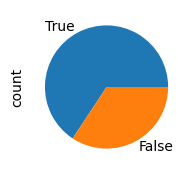

In [316]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

## Get confusion matrix

In [299]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [300]:
CM.style.background_gradient(axis=None)

doc_label,A,B,C
prediction,,,
A,4980,1712,390
B,1389,3411,1647
C,180,1403,4496


In [301]:
(CM / CM.sum()).style.format(precision=2).background_gradient(axis=1)

doc_label,A,B,C
prediction,,,
A,0.76,0.26,0.06
B,0.21,0.52,0.25
C,0.03,0.21,0.69


In [302]:
(CM.T / CM.T.sum()).T.style.format(precision=2).background_gradient(axis=0)

doc_label,A,B,C
prediction,,,
A,0.70,0.24,0.06
B,0.22,0.53,0.26
C,0.03,0.23,0.74


In [303]:
from sklearn.naive_bayes import MultinomialNB

In [304]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
RESULT_mnb = pd.DataFrame(dict(prediction=clf.predict(X_test)), index=X_test.index)

In [305]:
RESULT_mnb['doc_label'] = y_test

In [306]:
RESULT_mnb['result'] = RESULT_mnb.prediction == RESULT_mnb.doc_label

In [307]:
CM_mnb = RESULT_mnb.value_counts(['doc_label', 'prediction']).unstack()

In [308]:
(CM_mnb / CM_mnb.sum()).style.format(precision=2).background_gradient(axis=0)

prediction,A,B,C
doc_label,,,
A,0.71,0.22,0.03
B,0.24,0.53,0.23
C,0.05,0.25,0.73


In [309]:
(CM_mnb.T / CM_mnb.T.sum()).T.style.format(precision=2).background_gradient(axis=1)

prediction,A,B,C
doc_label,,,
A,0.75,0.22,0.03
B,0.25,0.53,0.22
C,0.05,0.24,0.70
